# Stone's Two-Index Model: A Consistent Factor Model for Life Insurance Sector

## Table of contents:

&nbsp;&nbsp;0. [Environment setup](#0)

&nbsp;&nbsp;1. [Preparation & Data Cleaning](#1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1 [Scraping Data](#1-1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2 [Missing values](#1-2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3 [Converting stock price to return](#1-3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.4 [Sanity check](#1-4)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.5 [Changing the frequency of observation](#1-5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.6 [Importing of risk-free rate (RFR) proxy, index return & diff interest rate](#1-6)

&nbsp;&nbsp;2. [Measuring the insurers' "bond systematic risk"](#2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Life insurers](#2-1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 [Non-Life insurers](#2-2)

&nbsp;&nbsp;3. [Concluding remarks](#3)

## <span style="text-decoration:underline">Summary </span>

Models factors are essential tools for asset management. In addition to their usual using, they can be useful in identifying sector- or industry-specific risk factors. The purpose of this brief study is precisely to use them for this purpose, for one of the most important financial sectors, the life insurance industry. Specifically, we examine the effects of interest rate changes on stock returns of European groups engaged in traditional life insurance using the standard OLS model and regularization algorithms for linear regression (LASSO with Cross-Validation, Ridge, Elastic Net). Using Stone's two-index model, the results indicate that the returns of insurers engaged in life insurance business are, for the recent period, more sensitive to interest rate changes than their non-life insurers.

### Disclaimers: 

This work is just a brief overview to highlight the sensitivity of the life insurance industry to the low interest rate environment over the past decade using the Python programming language. 

Many corrections need to be made to match academic standards, such as :
- Make a comparison with a normal interest rate environment
- Increase the sample size
- Not using scrapping data
- Using the reinvested dividend return 
- Treatment of heteroscedasticity 
- More rigorous management of multi-nationality in samples

These corrections have been made in the 1st chapter of our thesis: https://theses.fr/s321393

## 0. Environment setup <a class="anchor" id="0"></a>

In [1106]:
# importing the necessary librairies
import datetime as dt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yfin
import warnings
warnings.filterwarnings("ignore")

from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

## 1. Preparation & Data Cleaning <a class="anchor" id="1"></a>

### 1.1 Scraping Data <a class="anchor" id="1-1"></a>

#### 1.1.1 Sample #1: Life insurers

In [1107]:
# Specify date range 
start = dt.datetime(2012,12,20)
end = dt.datetime(2017,12,31)

In [1108]:
# Specify the stocks
stocks_life =   ['0GDR.IL', # Uniqa 
                'VIG.VI', # Vienna Insurance Group
                'AGS.BR', # AGEAS
                'ALV.F', # Allianz SE
                'NBG6.DE', # Nürnberger Beteiligungs
                'G.MI', # Generali Assicurazioni S.P.A.
                'UNI.MI', # Unipol Gruppo Finanziario
                'NN.AS', # Nationale-Nederlanden
                'AGN.AS', # Aegon                
                'SREDF', # Storebrand
                'BALN.SW', # Bâloise Holding AG
                'HELN.SW', # Helvetia Holding AG
                'SLHN.SW', # Swiss Life   
                'AV.L', # AVIVA        
                'CSN.L', # Chesnara                                                                      
                'PRU.L' # Prudential                  
                ]

#### Note: 

Among the european insurers, we have included in our "life insurer" sample, the groups with a total sales coming from at least 20% of the premiums collected from traditional life insurance. This threshold, although insufficient to qualify the groups exceeding it as life insurers, nevertheless corresponds to a level of commitment high enough to generate, to varying degrees, exposure to the risks associated with this sector of activity.

In [1109]:
# Reading data
yfin.pdr_override() 
df_stock_life = pdr.get_data_yahoo(stocks_life, start, end)

[*********************100%***********************]  16 of 16 completed


In [1110]:
# Select only close prices
Close_life = df_stock_life.Close

#### 1.1.2 Sample #2: Non-Life insurers

In [1111]:
# Specify the stocks
stocks_non_life =   ['TOP.CO', # Topdanmark
                    'ALMB.CO', # Alm Brand
                    'SAMPO.HE', # Sampo Group
                    'CS.PA', # AXA Group
                    'SCR.PA', # Scor Se
                    '0M9A.IL', # Hannover Re
                    'MUV2.DE', # Münchener Rück
                    'GCO.MC', # Grupo Catalana Occidente
                    'MAP.MC', # Mapfre
                    'SREN.SW', # Swiss Re
                    'VAHN.SW',# Vaudoise Assurances
                    'ZURN.SW', # Zurich Financial Services Group 
                    'ADM.L', # Admiral Group 
                    'BEZ.L', # Beazley
                    'LGEN.L', # Legal & General
                    'PGH.L', # Personal Group Holdings
                    'RSAB.L', # RSA Insurance Group          
                    'STJ.L' # St. James's Place                                                                                                                                                                    
                     ]

#### Note: 

This second sample, also composed of european insurers but whose premiums collected from traditional life insurance represent less than 20 percent of their total sales, will serve as a control group.

In [1112]:
# Reading data
yfin.pdr_override() 
df_stocks_non_life = pdr.get_data_yahoo(stocks_non_life, start, end)

[*********************100%***********************]  18 of 18 completed


In [1113]:
# Select only close prices
Close_non_life = df_stocks_non_life.Close

### 1.2 Missing values <a class="anchor" id="1-2"></a>

#### 1.2.1 Sample #1: Life insurers

In [1114]:
# Checking missing values
Close_life.count()

0GDR.IL    1270
AGN.AS     1283
AGS.BR     1282
ALV.F      1274
AV.L       1270
BALN.SW    1258
CSN.L      1270
G.MI       1273
HELN.SW    1258
NBG6.DE    1272
NN.AS       896
PRU.L      1270
SLHN.SW    1258
SREDF      1266
UNI.MI     1273
VIG.VI     1247
dtype: int64

We deleted NN.AS (Nationale-Nederlanden) because of too many missing values.

For the others, since there are only a few missing values for some companies, the easiest way to deal with the missing values is to delete the row (i.e. the date) for all companies where a missing value has appeared.

In [1115]:
Close_life = Close_life.drop(["NN.AS"], axis=1)

In [1116]:
# Drop rows which contain missing values
Close_life = Close_life.dropna() 

In [1117]:
Close_life.count()

0GDR.IL    1194
AGN.AS     1194
AGS.BR     1194
ALV.F      1194
AV.L       1194
BALN.SW    1194
CSN.L      1194
G.MI       1194
HELN.SW    1194
NBG6.DE    1194
PRU.L      1194
SLHN.SW    1194
SREDF      1194
UNI.MI     1194
VIG.VI     1194
dtype: int64

#### 1.2.2 Sample #2: Non-life insurers

In [1118]:
# Checking missing values
Close_non_life.count()

0M9A.IL     1270
ADM.L       1270
ALMB.CO     1251
BEZ.L       1270
CS.PA       1282
GCO.MC      1284
LGEN.L      1270
MAP.MC      1284
MUV2.DE     1272
PGH.L       1270
RSAB.L      1270
SAMPO.HE    1260
SCR.PA      1282
SREN.SW     1258
STJ.L       1270
TOP.CO      1251
VAHN.SW     1258
ZURN.SW     1258
dtype: int64

In [1119]:
# Drop rows which contain missing values
Close_non_life = Close_non_life.dropna() 

In [1120]:
Close_non_life.count()

0M9A.IL     1210
ADM.L       1210
ALMB.CO     1210
BEZ.L       1210
CS.PA       1210
GCO.MC      1210
LGEN.L      1210
MAP.MC      1210
MUV2.DE     1210
PGH.L       1210
RSAB.L      1210
SAMPO.HE    1210
SCR.PA      1210
SREN.SW     1210
STJ.L       1210
TOP.CO      1210
VAHN.SW     1210
ZURN.SW     1210
dtype: int64

### 1.3 Converting stock price to return <a class="anchor" id="1-3"></a>

#### 1.3.1 Sample #1: Life insurers

In [1121]:
# Convert to return
returns_life = Close_life.pct_change()

# Drop the first row
returns_life = returns_life.dropna() 

display(returns_life)

,0GDR.IL,AGN.AS,AGS.BR,ALV.F,AV.L,BALN.SW,CSN.L,G.MI,HELN.SW,NBG6.DE,PRU.L,SLHN.SW,SREDF,UNI.MI,VIG.VI
Date,,,,,,,,,,,,,,,
2012-12-21,0.000,-0.013,-0.009,-0.001,-0.003,-0.008,0.021,0.005,-0.013,-0.023,-0.026,-0.010,0.000,-0.008,0.023
2012-12-27,0.000,-0.002,0.015,0.001,-0.005,0.001,-0.019,0.000,0.011,0.024,0.006,0.001,0.000,0.013,0.000
2012-12-28,0.000,-0.008,-0.014,-0.006,-0.013,-0.008,-0.005,-0.006,-0.006,0.005,-0.014,-0.007,0.000,0.000,0.002
2013-01-03,0.000,0.046,0.051,0.032,0.023,0.029,0.025,0.046,0.022,0.000,0.049,0.026,0.000,0.039,0.009
2013-01-04,0.000,0.013,-0.005,0.000,0.007,0.011,0.003,0.000,0.008,0.026,0.012,0.010,0.000,0.025,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,0.011,0.001,-0.008,0.002,0.003,0.003,-0.014,-0.004,0.003,-0.007,0.010,0.006,0.000,0.008,0.007
2017-12-22,0.000,-0.003,0.003,-0.005,-0.001,-0.006,0.030,0.003,-0.004,0.006,0.004,-0.006,0.000,-0.004,0.008
2017-12-27,0.000,-0.004,-0.003,-0.002,0.000,0.003,-0.021,-0.002,0.004,0.001,-0.001,0.004,0.028,0.013,-0.014


#### 1.3.2 Sample #2: Non-life insurers

In [1122]:
# Convert to return
returns_non_life = Close_non_life.pct_change()

# Drop the first row
returns_non_life = returns_non_life.dropna() 

display(returns_non_life)

,0M9A.IL,ADM.L,ALMB.CO,BEZ.L,CS.PA,GCO.MC,LGEN.L,MAP.MC,MUV2.DE,PGH.L,RSAB.L,SAMPO.HE,SCR.PA,SREN.SW,STJ.L,TOP.CO,VAHN.SW,ZURN.SW
Date,,,,,,,,,,,,,,,,,,
2012-12-21,-0.008,0.006,-0.007,0.003,0.007,-0.030,-0.007,0.024,0.007,-0.001,0.000,0.002,0.005,0.000,-0.010,0.001,0.001,0.005
2012-12-27,0.006,-0.002,0.007,0.016,0.006,-0.022,0.003,-0.015,-0.001,0.000,0.000,0.002,0.000,-0.003,0.002,-0.002,-0.008,-0.001
2012-12-28,-0.011,-0.018,0.007,-0.003,-0.017,-0.011,-0.011,-0.006,-0.010,-0.011,0.000,-0.008,-0.007,-0.012,0.008,-0.003,-0.003,-0.006
2013-01-03,0.020,0.020,0.029,0.021,0.045,0.047,0.027,0.044,0.015,-0.015,0.000,0.033,0.014,0.027,0.028,0.016,0.024,0.021
2013-01-04,-0.010,0.002,-0.007,0.007,0.003,0.032,0.010,0.001,0.001,0.028,0.000,0.009,0.007,0.005,0.005,0.011,0.010,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,-0.007,0.003,0.000,0.033,0.001,-0.001,0.004,0.016,-0.001,0.006,0.004,0.002,-0.006,0.009,0.008,-0.012,0.009,0.006
2017-12-22,-0.001,-0.006,0.000,0.013,-0.005,-0.029,0.003,-0.006,-0.004,0.000,0.000,-0.002,-0.004,-0.004,0.001,-0.001,0.000,-0.006
2017-12-27,-0.002,0.017,0.013,0.015,-0.004,0.005,-0.002,0.000,-0.003,0.000,0.000,0.001,-0.004,0.002,0.007,0.005,-0.011,0.001


### 1.4 Sanity check <a class="anchor" id="1-4"></a>

#### 1.4.1 Sample #1: Life insurers

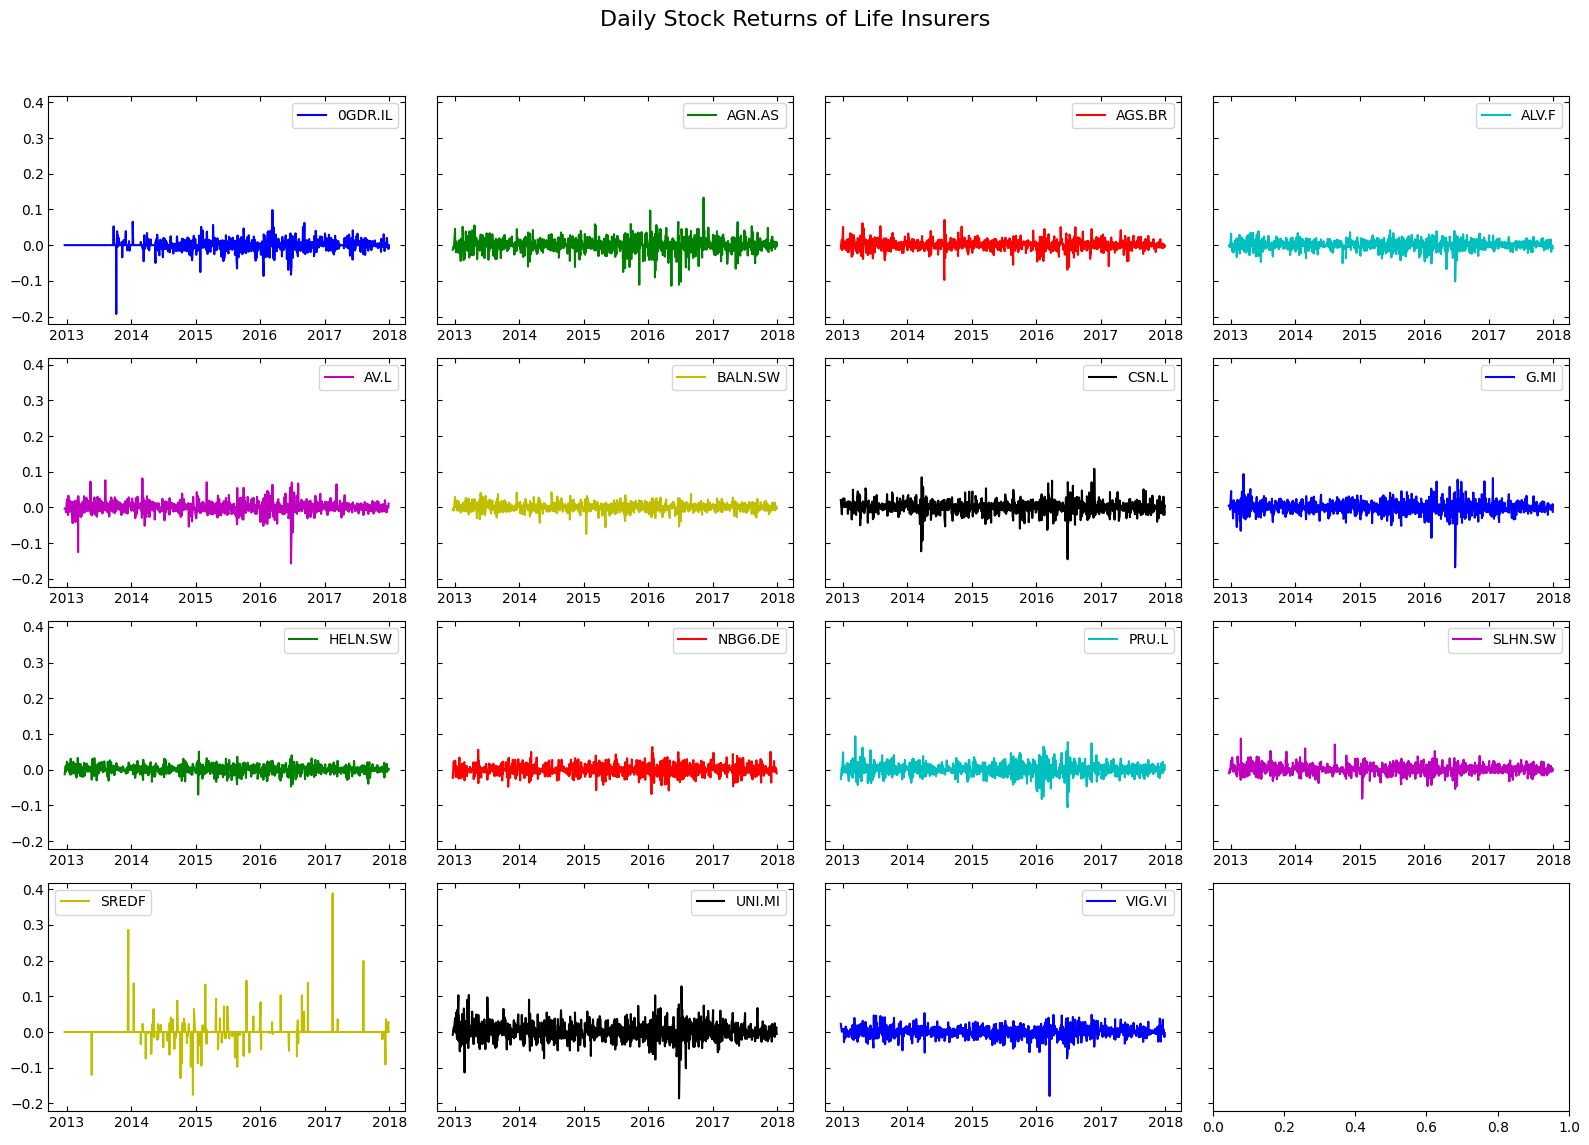

In [1123]:
n = len(returns_life.columns)
col = 4
row = int(np.ceil(n/col))
fig_hei = row * 3
fig_wid = col * 4

fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(fig_wid, fig_hei), sharey=True)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, col_name in enumerate(returns_life.columns):
    r = i // col
    c = i % col
    ax = axes[r, c]
    ax.plot(returns_life[col_name], color=colors[i%len(colors)])
    ax.set_title('')
    ax.tick_params(axis='both', which='both', top = True, direction='in', right=True)
    ax.legend([col_name], loc='best')

fig.suptitle('Daily Stock Returns of Life Insurers', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1124]:
# Basic statistics 
returns_life.describe()

,0GDR.IL,AGN.AS,AGS.BR,ALV.F,AV.L,BALN.SW,CSN.L,G.MI,HELN.SW,NBG6.DE,PRU.L,SLHN.SW,SREDF,UNI.MI,VIG.VI
count,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000,1193.000
mean,0.000,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.000,0.000,0.001,0.001,0.001,0.001,-0.000
std,0.015,0.020,0.014,0.013,0.017,0.011,0.018,0.018,0.012,0.014,0.017,0.013,0.022,0.025,0.016
min,-0.193,-0.114,-0.097,-0.102,-0.157,-0.074,-0.145,-0.168,-0.070,-0.068,-0.105,-0.081,-0.176,-0.186,-0.179
25%,-0.004,-0.009,-0.006,-0.005,-0.008,-0.006,-0.008,-0.009,-0.006,-0.006,-0.008,-0.006,0.000,-0.013,-0.009
50%,0.000,0.001,0.001,0.001,-0.000,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.000
75%,0.005,0.011,0.008,0.008,0.008,0.007,0.009,0.010,0.007,0.007,0.010,0.008,0.000,0.015,0.009
max,0.098,0.133,0.071,0.042,0.081,0.042,0.108,0.094,0.051,0.064,0.093,0.087,0.389,0.128,0.053


#### Notes: 
- We can already observe daily returns with strong variations, mainly for AEGON, UNIPOL & VIENNE INSURANCE.
- We prefer to remove Uniqa (0GDR.IL) and Storebrand (SREDF), which are characterized by particularly atypical returns.
- As done in our thesis, many statistical tests must be performed before considering exploiting these variables.

In [1125]:
returns_life = returns_life.drop(["0GDR.IL","SREDF"], axis=1)

#### 1.4.2 Sample #2: Non-life insurers

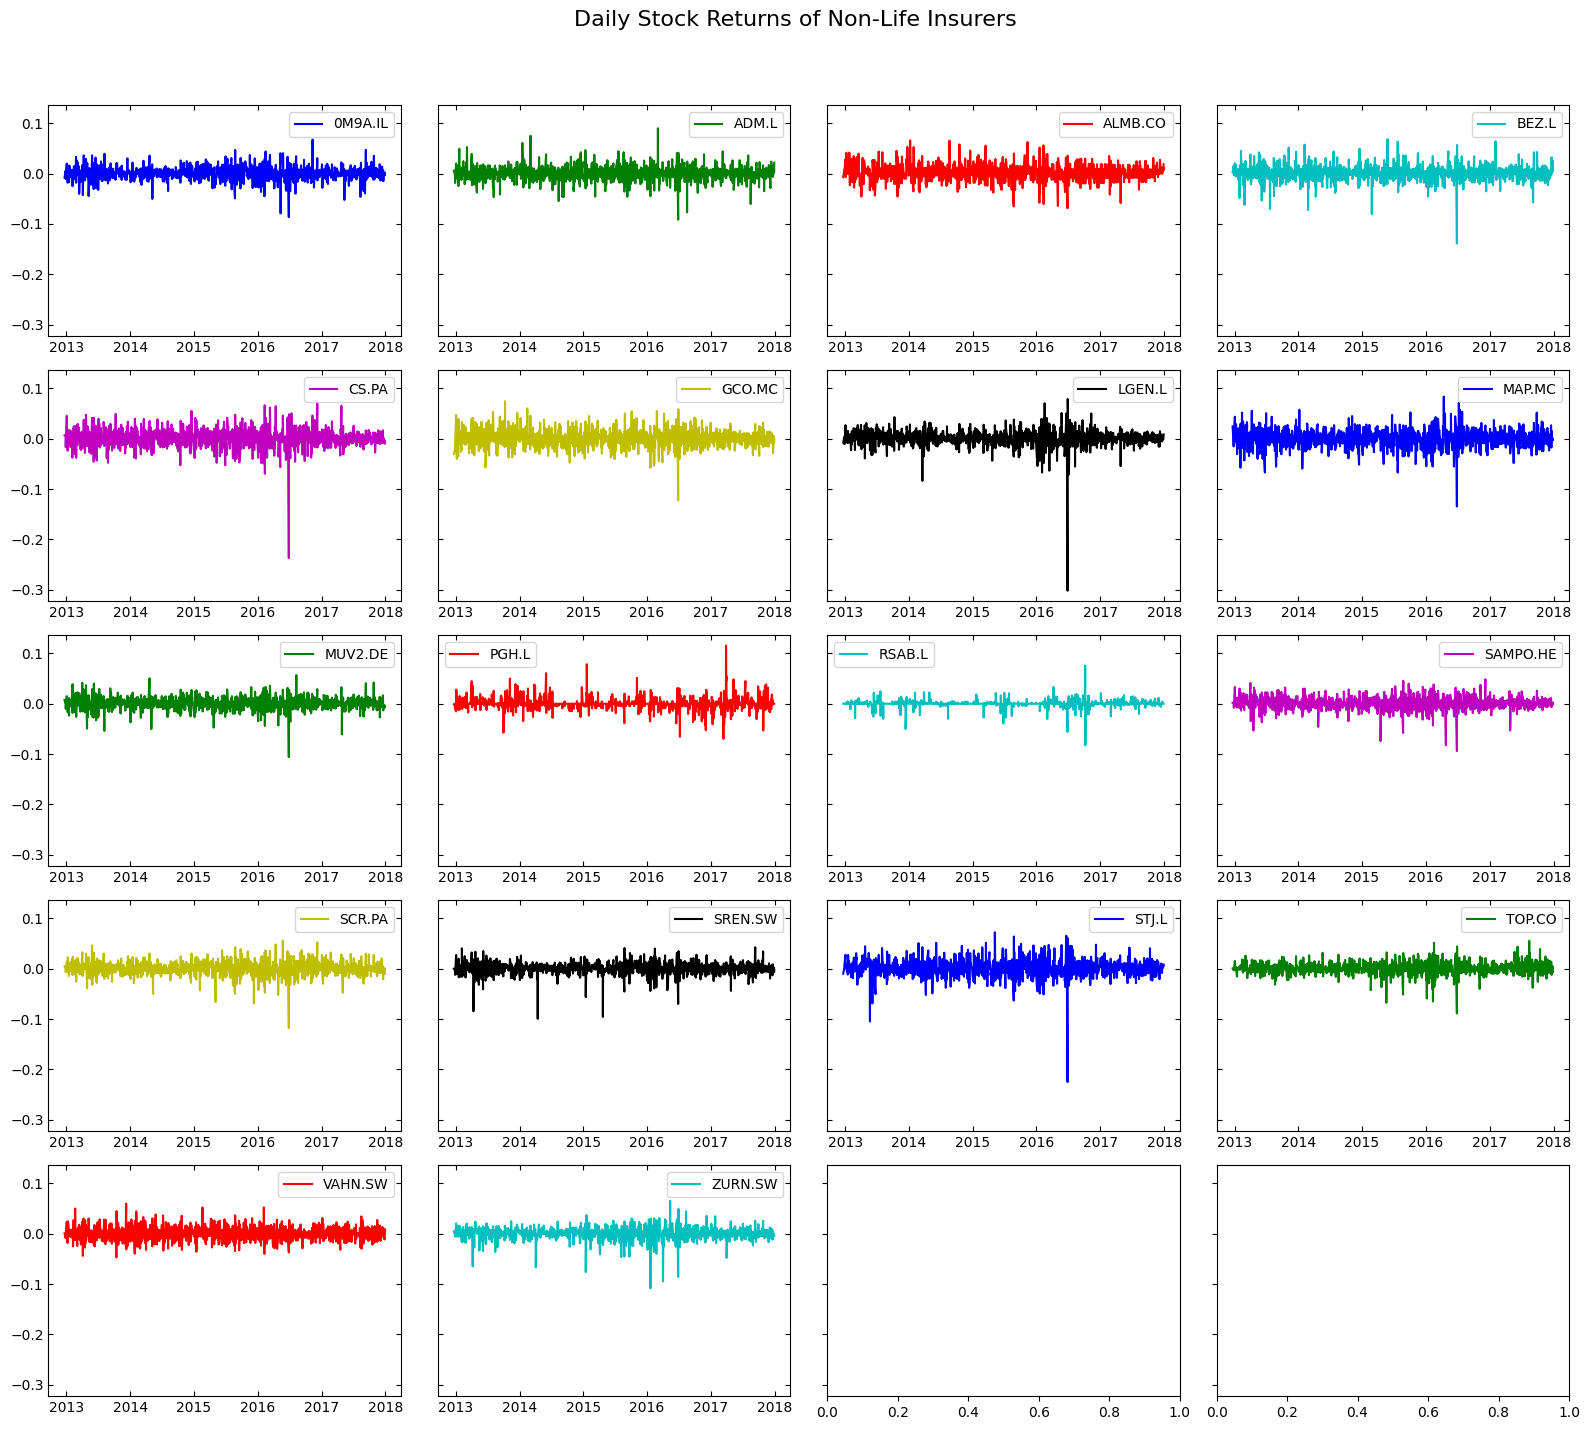

In [1126]:
n = len(returns_non_life.columns)
col = 4
row = int(np.ceil(n/col))
fig_hei = row * 3
fig_wid = col * 4

fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(fig_wid, fig_hei), sharey=True)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, col_name in enumerate(returns_non_life.columns):
    r = i // col
    c = i % col
    ax = axes[r, c]
    ax.plot(returns_non_life[col_name], color=colors[i%len(colors)])
    ax.set_title('')
    ax.tick_params(axis='both', which='both', top = True, direction='in', right=True)
    ax.legend([col_name], loc='best')

fig.suptitle('Daily Stock Returns of Non-Life Insurers', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1127]:
# Basic statistics 
returns_non_life.describe()

,0M9A.IL,ADM.L,ALMB.CO,BEZ.L,CS.PA,GCO.MC,LGEN.L,MAP.MC,MUV2.DE,PGH.L,RSAB.L,SAMPO.HE,SCR.PA,SREN.SW,STJ.L,TOP.CO,VAHN.SW,ZURN.SW
count,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000,1209.000
mean,0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.000
std,0.013,0.014,0.016,0.015,0.018,0.016,0.017,0.018,0.012,0.012,0.007,0.013,0.014,0.012,0.018,0.012,0.012,0.013
min,-0.086,-0.091,-0.069,-0.139,-0.237,-0.122,-0.302,-0.135,-0.106,-0.070,-0.083,-0.094,-0.118,-0.099,-0.225,-0.089,-0.047,-0.108
25%,-0.006,-0.006,-0.007,-0.006,-0.009,-0.008,-0.006,-0.010,-0.006,-0.002,0.000,-0.006,-0.007,-0.005,-0.008,-0.006,-0.006,-0.005
50%,0.001,0.000,0.000,0.001,0.001,0.001,0.001,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.000
75%,0.007,0.008,0.010,0.008,0.010,0.009,0.008,0.011,0.007,0.002,0.000,0.007,0.008,0.007,0.010,0.007,0.007,0.006
max,0.068,0.090,0.066,0.069,0.070,0.074,0.079,0.084,0.057,0.116,0.076,0.049,0.056,0.043,0.072,0.056,0.060,0.066


#### Note: 
- We can already observe daily returns with sharp variations, mainly for AXA, GRUPO CATALANA OCCIDENTE & MUNICH RE.

### 1.5 Change in the frequency of observation <a class="anchor" id="1-5"></a>

For this analysis, we decide to change the frequency of observations from daily to weekly.

#### 1.5.1 Sample #1: Life insurers

In [1128]:
# Calculation from the daily cumulative return
returns_weekly_life = (returns_life+1).resample('W').prod() - 1 

# Remove the returns data for the first week
returns_weekly_life = returns_weekly_life.drop(returns_weekly_life.index[[0]]) 

# Remove the returns data for the last week
df_week = returns_weekly_life.drop(returns_weekly_life.index[[-1]]) 

#### 1.5.2 Sample #2: Non-life insurers

In [1129]:
# Convert daily return data to weekly return
returns_weekly_non_life = (returns_non_life+1).resample('W').prod() - 1 

# Remove the returns data for the first week
returns_weekly_non_life = returns_weekly_non_life.drop(returns_weekly_non_life.index[[0]])

# Remove the returns data for the last week
returns_weekly_non_life = returns_weekly_non_life.drop(returns_weekly_non_life.index[[-1]]) 

### 1.6 Importing of risk-free rate (RFR) proxy, index return & Δ interest rate<a class="anchor" id="1-6"></a>

#### 1.6.1 RFR proxy

Since we are dealing with companies based in different countries, the choice of the RFR is a tricky issue. 

Among the different options available, we choose the Germany 3M Bond as RFR.

In [1130]:
## Read csv file
GEM3M = pd.read_csv("M:/Cours/Investment Management with Python and Machine Learning/Projet/data/Germany3M.csv", usecols=["Date", "Price"])

# Select "Date" column and convert to datatime object 
GEM3M['Date']=pd.to_datetime(GEM3M['Date']) 

# Select "Price" and convert to numeric format
GEM3M['Price'] = pd.to_numeric(GEM3M['Price'], errors='coerce') 

# Create a new dataframe with as index the "Date" of GEM3M and a column "Return"
GEM3M_data=pd.DataFrame(columns=['Return'], index=GEM3M.Date) 

# Convert to weekly return
GEM3M_data['Return'] = (GEM3M['Price'].values/100 + 1) ** (1/52) - 1 
GEM3M_weekly = (GEM3M_data['Return']+1).resample('W').prod() - 1

# Create a new dataframe using a weekly index 
GEM3M = pd.DataFrame(columns=['GEM-3M'], index=GEM3M_weekly.index)

# Insert weekly return of GEM-3M into new dataframe
GEM3M['GEM-3M'] = GEM3M_weekly

# Check the match of day of weekly observation (i.e. index) between "GEM3M" and "returns_life"
ind = (GEM3M.index >= returns_life.index[[0]][0])*(GEM3M.index <= returns_life.index[[-1]][0])
GEM3M = GEM3M[ind] 

In [1131]:
# Check the correspondence between the "returns_weekly_life" index and the "GEM3M_life" index
display(returns_weekly_life)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
display(GEM3M)

,AGN.AS,AGS.BR,ALV.F,AV.L,BALN.SW,CSN.L,G.MI,HELN.SW,NBG6.DE,PRU.L,SLHN.SW,UNI.MI,VIG.VI
Date,,,,,,,,,,,,,
2012-12-30,-0.011,0.000,-0.005,-0.018,-0.008,-0.024,-0.006,0.005,0.029,-0.008,-0.007,0.013,0.003
2013-01-06,0.060,0.046,0.033,0.030,0.041,0.028,0.046,0.031,0.026,0.061,0.037,0.065,0.013
2013-01-13,-0.004,0.013,-0.023,-0.018,0.017,0.057,0.013,0.032,-0.020,0.004,0.063,0.097,-0.037
2013-01-20,-0.012,0.014,-0.013,-0.037,0.006,0.029,-0.037,0.018,-0.008,0.010,0.016,0.066,-0.003
2013-01-27,-0.008,0.018,0.010,0.012,0.004,0.017,0.007,0.003,-0.012,0.018,0.019,0.122,-0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-03,0.005,0.006,-0.008,0.014,-0.006,0.116,-0.011,-0.000,-0.036,-0.036,-0.022,-0.006,0.033
2017-12-10,0.022,0.025,0.011,0.007,0.009,-0.016,0.015,-0.006,0.015,0.011,0.009,0.015,-0.016
2017-12-17,0.010,-0.012,-0.008,-0.015,0.007,0.014,0.011,0.013,0.035,0.007,0.035,0.004,0.003


,GEM-3M
Date,
2012-12-23,0.000000
2012-12-30,0.000003
2013-01-06,0.000004
2013-01-13,0.000012
2013-01-20,0.000010
...,...
2017-11-26,-0.000178
2017-12-03,-0.000197
2017-12-10,-0.000202


#### Note: 
- A gap of one observation between the two dataframes 

#### 1.6.2 Return of european stock market index

As a stock index (needed for the beta calculations in the next section), we choose the Euro Stoxx 50.

We extract the performance of the index for the same date range as the insurers' stock prices and then convert it to a return.

In [1132]:
# Specify date range 
start = dt.datetime(2012,12,25)
end = dt.datetime(2017,12,31)

# Specify the index
STOXX50E = ['^STOXX50E'] # Euro Stoxx 50

# Reading data
df_STOXX50E = pdr.get_data_yahoo(STOXX50E, start, end)

# Select only close prices
Close_STOXX50E = df_STOXX50E.Close

# Convert to return
returns_STOXX50E = Close_STOXX50E.pct_change()

# Drop the first rows
returns_STOXX50E = returns_STOXX50E.dropna() 

# Calculation of weekly return from the daily cumulative return
returns_STOXX50E_weekly = (returns_STOXX50E+1).resample('W').prod() - 1 

# Remove the returns data for the first week
returns_STOXX50E_weekly = returns_STOXX50E_weekly.drop(returns_STOXX50E_weekly.index[[0]]) 

# Remove the returns data for the last week
returns_STOXX50E_weekly = returns_STOXX50E_weekly.drop(returns_STOXX50E_weekly.index[[-1]]) 

display(returns_STOXX50E_weekly)

[*********************100%***********************]  1 of 1 completed


Date
2013-01-06    0.031406
2013-01-13    0.003115
2013-01-20   -0.003017
2013-01-27    0.012766
2013-02-03   -0.012426
                ...   
2017-11-26    0.009519
2017-12-03   -0.014989
2017-12-10    0.018115
2017-12-17   -0.008609
2017-12-24   -0.002005
Freq: W-SUN, Name: Close, Length: 260, dtype: float64

#### 1.6.3 	Variation of interest rate

##### Theoretical point

Let us first discuss this explanatory variable.

It was introduced by Stone (1974) to improve the predictive capacity of the CAPM. According to this author, there is competition between bonds and stocks when constructing the optimal portfolio. Thus, the price of a stock evolves, through its risk premiums, not only according to its sensitivity to variations in the stock market (stock systematic risk), but also according to its sensitivity to variations in the bond market (bond systematic risk).

The two-index model, originally constructed to improve the CAPM, can also be used as an approximation of the sensitivity of stocks to interest rates.

##### Now back to our study.

For the same reason as for the RFR (i.e., dealing with companies based in different countries), the choice of interest rate is also a tricky issue. 

The option chosen was to construct a composite interest rate from the government bonds of the different countries where the insurers in our sample are based. We then calculate the difference between two observations.

#### Note: 
- Since each stock is regressed individually, it would be better to link each stock to its country's government bond. But for this brief study, we prefer to construct a composite bond index. This data, in the form of a CSV file, is downloaded.

In [1133]:
## Read csv file
ΔI = pd.read_csv("M:/Cours/Investment Management with Python and Machine Learning/Projet/data/DeltaI.csv", usecols=["Date", "DPB"])

# Select "date" column and convert to datatime object 
ΔI['Date']=pd.to_datetime(ΔI['Date']) 

# Select "Price" and convert to numeric format
ΔI['DPB'] = pd.to_numeric(ΔI['DPB'], errors='coerce') 

# Create a new dataframe 
Δ_I = pd.DataFrame(columns=['Date','Δ_I'])
for i in range(1, len(ΔI)):
    date = ΔI.iloc[i]['Date']
    dpb = ΔI.iloc[i]['DPB']
    Δ_I = Δ_I.append({'Date': date, 'Δ_I': dpb}, ignore_index=True)

# Mettre en index "Date"
Δ_I.index = pd.to_datetime(Δ_I.index, format='%Y-%m-%d')
Δ_I = Δ_I.set_index('Date')

Δ_I = Δ_I.sort_index(ascending=True)
Δ_I['Δ_I'] = Δ_I['Δ_I'].div(100)
print(Δ_I)

                 Δ_I
Date                
2010-07-04 -0.041258
2010-07-11  0.012944
2010-07-18  0.025949
2010-07-25 -0.040254
2010-08-01 -0.040254
...              ...
2017-11-19 -0.021415
2017-11-26 -0.039044
2017-12-03 -0.039044
2017-12-10 -0.009364
2017-12-17 -0.021897

[390 rows x 1 columns]


In [1134]:
# Check and find location of missing values
nan_loc = Δ_I.loc[Δ_I['Δ_I'].isna()].index
print(nan_loc)

DatetimeIndex(['2016-09-18', '2016-10-23'], dtype='datetime64[ns]', name='Date', freq=None)


In [1135]:
# Replacing of the 2 missing values by the mean of the variable
mean_DPB = Δ_I['Δ_I'].mean()
Δ_I['Δ_I'].fillna(mean_DPB, inplace=True)

## 2. Measuring the insurers' "bond systematic risk"<a class="anchor" id="2"></a>

In [1136]:
# Specify a data range for the analysis (note: we begin the start date after the highest stress of the European sovereign debt crisis, i.e. 2011-2012).
start_date, end_date = pd.to_datetime(['2013-01-01', '2017-12-20'])

# Select common data including into date range
GEM3M = GEM3M.loc[start_date:end_date]
STOXX50E = returns_STOXX50E_weekly.loc[start_date:end_date]
Δ_I = Δ_I.loc[start_date:end_date]

### 2.1 Life insurers<a class="anchor" id="2-1"></a>

In [1137]:
# Select life insurers' returns into the date range specified
ind = (returns_weekly_life.index >= start_date) & (returns_weekly_life.index <= end_date)
returns_weekly_life = returns_weekly_life.loc[ind]

#### 2.1.1 Basic statistics 

In [1138]:
# Frequency factor (i.e. 52 since weekly data)
Freq = 52 

# Annualization functions for returns and standard deviation
def ann_ret(x):
    return (x+1)**Freq-1
def ann_std(x):
    return x*np.sqrt(Freq)

# Function used to find the annualized geometric mean 
def ann_geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * Freq / n) - 1

# Annualization function for Sharpe ratio 
def ann_sr(x, rf):    
    n = len(x)
    ret_expected = np.sum(x-rf)/n
    ret_avg = np.sum(x)/n
    std_dev = np.sqrt( np.sum( (x - ret_avg)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**Freq-1
    annu_std_dev = std_dev * np.sqrt(Freq)
    return annu_ret_expected/annu_std_dev

# Annualization function for Maximum drawdown
def mdd(x):
    wealth = (x+1).cumprod() 
    cummax = wealth.cummax() 
    drawdown = wealth/cummax - 1 
    return drawdown.min()

In [1139]:
# Basic statistics about returns:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
n_dec = 2
BasicStat = pd.DataFrame(index = returns_weekly_life.columns)
BasicStat['Mean(%)'] = np.round(returns_weekly_life.apply(ann_geo_mean)*100, n_dec)
BasicStat['Volatility(%)'] = np.round( ann_std(returns_weekly_life.std())*100 , n_dec)
BasicStat['Sharpe Ratio'] = np.round(returns_weekly_life.apply(ann_sr, rf=GEM3M['GEM-3M']) , n_dec)
BasicStat['Max Drawdown(%)'] = np.round(returns_weekly_life.apply(mdd)*100, n_dec)
BasicStat.loc['Average'] = BasicStat.mean()
display(BasicStat)

,Mean(%),Volatility(%),Sharpe Ratio,Max Drawdown(%)
AGN.AS,2.12,31.29,0.24,-56.59
AGS.BR,13.30,20.73,0.78,-30.94
ALV.F,13.60,20.54,0.80,-27.60
AV.L,6.01,22.74,0.40,-36.32
BALN.SW,14.28,17.13,0.96,-22.24
CSN.L,15.34,23.38,0.81,-25.00
G.MI,2.38,24.84,0.24,-43.41
HELN.SW,9.46,16.81,0.68,-15.03
NBG6.DE,3.17,15.91,0.30,-30.73
PRU.L,16.46,23.88,0.85,-33.76


#### 2.1.2 CAPM

In [1140]:
# Linear Regression
def LR(X,y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1)) 
    return reg.coef_,reg.intercept_

# Rounding to this decimal
n_dec = 3

# Create a table structure for the results 
def capm_table(columns):
    capm = pd.DataFrame(index = returns_weekly_life.columns)
    capm['Alpha']  = np.round(ann_ret(alpha)*100, n_dec)
    capm['Beta']   = np.round(beta, n_dec)
    capm = capm[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return capm

In [1141]:
# Get the excess return of stocks and index
ex_ret = returns_weekly_life.sub(GEM3M['GEM-3M'], axis=0)
mkt_ex_ret = STOXX50E.sub(GEM3M['GEM-3M'], axis=0)

# Calculate the alpha and beta of each stock
n = len(ex_ret.columns)
beta = np.zeros(n)
alpha = np.zeros(n)
for i in range(n):
    beta[i],alpha[i] = LR(mkt_ex_ret.values,ex_ret[ex_ret.columns[i]].values)
    
# Display alpha et bêta
capm_table = capm_table(['Alpha', 'Beta'])
display(capm_table)

,Alpha,Beta
AGN.AS,-1.762,1.155
AGS.BR,9.032,0.805
ALV.F,7.739,0.985
AV.L,2.204,0.838
BALN.SW,10.871,0.616
CSN.L,17.619,0.140
G.MI,-2.087,1.001
HELN.SW,6.259,0.601
NBG6.DE,3.510,0.162
PRU.L,11.418,0.967


#### 2.1.3 Two-Index Model

In [1142]:
## Tables

# Create a table structure for the ols results
def create_stone_life_table_ols(columns):
    stone = pd.DataFrame(index=returns_weekly_life.columns)
    stone['Alpha'] = np.round(ann_ret(alpha) * 100, n_dec)
    stone['p-value Alpha'] = np.round(pvalues_alpha, n_dec)
    stone['Beta-stock'] = np.round(beta_stock, n_dec)
    stone['p-value Beta-stock'] = np.round(pvalues_beta_stock, n_dec)
    stone['Beta-bond'] = np.round(beta_bond, n_dec)
    stone['p-value Beta-bond'] = np.round(pvalues_beta_bond, n_dec)
    stone = stone[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return stone

# Create a table structure for the results
def create_stone_life_table(columns):
    stone = pd.DataFrame(index=returns_weekly_life.columns)
    stone['Alpha'] = np.round(ann_ret(alpha) * 100, n_dec)
    stone['Beta-stock'] = np.round(beta_stock, n_dec)
    stone['Beta-bond'] = np.round(beta_bond, n_dec)
    stone.loc['Average'] = stone.mean()
    stone = stone[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return stone

##### LinearRegression

In [1143]:
# Linear regression
def LR(X,y):
    reg = LinearRegression().fit(X, y)
    if len(reg.coef_) == 2:
        return reg.coef_[0], reg.coef_[1], reg.intercept_
    else:
        return reg.coef_, 0, reg.intercept_

# Adding Δ interest rate as explanatory variable
bond_mkt_ex_ret = Δ_I.sub(GEM3M['GEM-3M'], axis=0)

# Calculate the alpha and beta of each stock, and their respective p-value
n = len(ex_ret.columns)
beta_stock = np.zeros(n)
beta_bond = np.zeros(n)
alpha = np.zeros(n)
pvalues_alpha = np.zeros(n)
pvalues_beta_stock = np.zeros(n)
pvalues_beta_bond = np.zeros(n)
for i in range(n):
    X = sm.add_constant(np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy())))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    model = sm.OLS(y, X)
    results = model.fit()
    beta_stock[i], beta_bond[i], alpha[i] = results.params[1], results.params[2], results.params[0]
    pvalues_alpha[i], pvalues_beta_stock[i], pvalues_beta_bond[i] = results.pvalues[0], results.pvalues[1], results.pvalues[2]

# Display results
stone_life_table = create_stone_life_table_ols(['Alpha', 'p-value Alpha', 'Beta-stock', 'p-value Beta-stock', 'Beta-bond', 'p-value Beta-bond'])
display(stone_life_table)

,Alpha,p-value Alpha,Beta-stock,p-value Beta-stock,Beta-bond,p-value Beta-bond
AGN.AS,0.397,0.971,1.168,0.000,0.107,0.000
AGS.BR,9.858,0.182,0.809,0.000,0.037,0.045
ALV.F,7.921,0.164,0.986,0.000,0.008,0.564
AV.L,2.994,0.713,0.842,0.000,0.038,0.073
BALN.SW,11.210,0.084,0.618,0.000,0.015,0.352
CSN.L,17.707,0.121,0.140,0.106,0.004,0.894
G.MI,-1.288,0.874,1.006,0.000,0.040,0.064
HELN.SW,6.813,0.275,0.604,0.000,0.026,0.107
NBG6.DE,3.391,0.638,0.162,0.006,-0.006,0.761
PRU.L,11.911,0.154,0.970,0.000,0.022,0.294


##### Lasso with Cross-Validation

In [1144]:
# Lasso with Cross-Validation
def LassoRegCV(X,y):
    reg = LassoCV(cv=5).fit(X, y)
    if len(reg.coef_) == 2:
        return reg.coef_[0], reg.coef_[1], reg.intercept_
    else:
        return reg.coef_, 0, reg.intercept_    

# Calculate the alpha and beta of each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = LassoRegCV(X, y)

# Display results
stone_life_table = create_stone_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_life_table)


,Alpha,Beta-stock,Beta-bond
AGN.AS,0.404,1.167,0.107
AGS.BR,9.863,0.809,0.037
ALV.F,8.057,0.963,0.006
AV.L,2.999,0.841,0.038
BALN.SW,11.318,0.600,0.013
CSN.L,18.533,0.041,0.000
G.MI,-1.282,1.005,0.040
HELN.SW,6.817,0.604,0.026
NBG6.DE,3.622,0.139,-0.004
PRU.L,11.917,0.969,0.022


##### Ridge Regression

In [1145]:
# Ridge Regression
def RidgeRegCV(X,y):
    reg = RidgeCV(cv=5).fit(X, y)
    if len(reg.coef_) == 2:
        return reg.coef_[0], reg.coef_[1], reg.intercept_
    else:
        return reg.coef_, 0, reg.intercept_

# Calculate the alpha and beta of each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = RidgeRegCV(X, y)

# Display results
stone_life_table = create_stone_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_life_table)

,Alpha,Beta-stock,Beta-bond
AGN.AS,4.031,0.682,0.094
AGS.BR,12.653,0.472,0.031
ALV.F,11.333,0.576,0.003
AV.L,5.726,0.492,0.031
BALN.SW,13.385,0.361,0.011
CSN.L,18.224,0.082,0.003
G.MI,1.857,0.587,0.033
HELN.SW,8.840,0.353,0.021
NBG6.DE,3.931,0.094,-0.006
PRU.L,15.366,0.566,0.016


##### Elastic Net Regression

In [1146]:
# Elastic Net Regression
def ElasticNetReg(X,y):
    reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5).fit(X, y)
    if len(reg.coef_) == 2:
        return reg.coef_[0], reg.coef_[1], reg.intercept_
    else:
        return reg.coef_, 0, reg.intercept_

# Calculate the alpha and beta of each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = ElasticNetReg(X, y)

# Display results
stone_life_table = create_stone_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_life_table)

,Alpha,Beta-stock,Beta-bond
AGN.AS,0.404,1.167,0.107
AGS.BR,9.950,0.798,0.037
ALV.F,8.057,0.963,0.006
AV.L,2.999,0.841,0.038
BALN.SW,11.480,0.584,0.014
CSN.L,18.142,0.083,0.000
G.MI,-1.275,1.004,0.040
HELN.SW,6.909,0.592,0.025
NBG6.DE,3.622,0.139,-0.004
PRU.L,11.921,0.968,0.022


### 2.2 Non-Life insurers <a class="anchor" id="2-2"></a>

In [1147]:
# Select non life insurers' returns for  the date range specified
ind = (returns_weekly_non_life.index >= start_date) & (returns_weekly_non_life.index <= end_date)
returns_weekly_non_life = returns_weekly_non_life.loc[ind]

#### 2.2.1 Basic statistics 

In [1148]:
# Basic statistics about returns:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
n_dec = 2
SumStat = pd.DataFrame(index = returns_weekly_non_life.columns)
SumStat['Geo Mean(Annu,%)'] = np.round(returns_weekly_non_life.apply(ann_geo_mean)*100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round( ann_std(returns_weekly_non_life.std())*100 , n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round(returns_weekly_non_life.apply(ann_sr, rf=GEM3M['GEM-3M']) , n_dec)
SumStat['Max Drawdown(%)'] = np.round(returns_weekly_non_life.apply(mdd)*100, n_dec)
SumStat.loc['Average'] = SumStat.mean()
display(SumStat)

,"Geo Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
0M9A.IL,12.73,20.34,0.76,-22.84
ADM.L,10.19,20.60,0.63,-23.62
ALMB.CO,41.18,24.26,1.89,-20.68
BEZ.L,22.19,21.55,1.18,-17.63
CS.PA,13.89,26.72,0.69,-33.16
GCO.MC,23.02,24.44,1.11,-28.31
LGEN.L,13.03,23.67,0.71,-39.65
MAP.MC,2.24,27.63,0.24,-51.57
MUV2.DE,6.52,19.61,0.46,-29.32
PGH.L,7.85,23.69,0.47,-55.65


#### 2.2.2 CAPM

In [1149]:
# Create a table structure for the results 
def capm_table(columns):
    capm = pd.DataFrame(index = returns_weekly_non_life.columns)
    capm['Alpha']  = np.round(ann_ret(alpha)*100, n_dec)
    capm['Beta']   = np.round(beta, n_dec)
    capm = capm[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return capm

In [1150]:
# Linear regression
def LR(X,y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))  # linear regression
    return reg.coef_,reg.intercept_

# Changing the serie for non-life insurers
ex_ret = returns_weekly_non_life.sub(GEM3M['GEM-3M'], axis=0)

# Computing alpha & beta with ols regression for each stock
n = len(ex_ret.columns)
beta = np.zeros(n)
alpha = np.zeros(n)
for i in range(n):
    beta[i],alpha[i] = LR(mkt_ex_ret.values,ex_ret[ex_ret.columns[i]].values)
    
# Display results
capm_table = capm_table(['Alpha', 'Beta'])
display(capm_table)

,Alpha,Beta
0M9A.IL,8.930,0.740
ADM.L,10.260,0.300
ALMB.CO,38.850,0.620
BEZ.L,22.330,0.320
CS.PA,8.500,1.110
GCO.MC,19.190,0.820
LGEN.L,10.360,0.710
MAP.MC,-2.170,1.080
MUV2.DE,2.720,0.750
PGH.L,9.910,0.150


#### 2.2.3 Two-Index Model

In [1151]:
## Tables

# Create a table structure for the ols results
def create_stone_non_life_table_ols(columns):
    stone = pd.DataFrame(index=returns_weekly_non_life.columns)
    stone['Alpha'] = np.round(ann_ret(alpha) * 100, n_dec)
    stone['p-value Alpha'] = np.round(pvalues_alpha, n_dec)
    stone['Beta-stock'] = np.round(beta_stock, n_dec)
    stone['p-value Beta-stock'] = np.round(pvalues_beta_stock, n_dec)
    stone['Beta-bond'] = np.round(beta_bond, n_dec)
    stone['p-value Beta-bond'] = np.round(pvalues_beta_bond, n_dec)
    stone = stone[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return stone

# Create a table structure for the results
def create_stone_non_life_table(columns):
    stone = pd.DataFrame(index=returns_weekly_non_life.columns)
    stone['Alpha'] = np.round(ann_ret(alpha) * 100, n_dec)
    stone['Beta-stock'] = np.round(beta_stock, n_dec)
    stone['Beta-bond'] = np.round(beta_bond, n_dec)
    stone.loc['Average'] = stone.mean()
    stone = stone[columns]
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return stone

##### OLS

In [1152]:
# Computing alpha & beta with ols regression for each stock
n = len(ex_ret.columns)
beta_stock = np.zeros(n)
beta_bond = np.zeros(n)
alpha = np.zeros(n)
pvalues_alpha = np.zeros(n)
pvalues_beta_stock = np.zeros(n)
pvalues_beta_bond = np.zeros(n)
for i in range(n):
    X = sm.add_constant(np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy())))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    model = sm.OLS(y, X)
    results = model.fit()
    beta_stock[i], beta_bond[i], alpha[i] = results.params[1], results.params[2], results.params[0]
    pvalues_alpha[i], pvalues_beta_stock[i], pvalues_beta_bond[i] = results.pvalues[0], results.pvalues[1], results.pvalues[2]

# Display results
stone_non_life_table = create_stone_non_life_table_ols(['Alpha', 'p-value Alpha', 'Beta-stock', 'p-value Beta-stock', 'Beta-bond', 'p-value Beta-bond'])
display(stone_non_life_table)

,Alpha,p-value Alpha,Beta-stock,p-value Beta-stock,Beta-bond,p-value Beta-bond
0M9A.IL,8.270,0.270,0.740,0.000,-0.030,0.120
ADM.L,10.280,0.280,0.300,0.000,0.000,0.970
ALMB.CO,37.560,0.000,0.620,0.000,-0.050,0.070
BEZ.L,22.600,0.030,0.330,0.000,0.010,0.660
CS.PA,9.890,0.270,1.120,0.000,0.060,0.010
GCO.MC,20.210,0.040,0.830,0.000,0.040,0.080
LGEN.L,10.780,0.270,0.710,0.000,0.020,0.440
MAP.MC,-1.650,0.860,1.090,0.000,0.030,0.280
MUV2.DE,2.050,0.760,0.750,0.000,-0.030,0.070
PGH.L,9.740,0.380,0.150,0.090,-0.010,0.800


##### Lasso Regression with Cross-Validation

In [1153]:
# Computing alpha & beta with Cross-Validation for each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = LassoRegCV(X, y)

# Display results
stone_non_life_table = create_stone_non_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_non_life_table)

,Alpha,Beta-stock,Beta-bond
0M9A.IL,8.280,0.740,-0.030
ADM.L,10.750,0.250,0.000
ALMB.CO,38.070,0.580,-0.040
BEZ.L,23.190,0.240,0.000
CS.PA,9.900,1.120,0.060
GCO.MC,20.220,0.830,0.040
LGEN.L,10.830,0.710,0.020
MAP.MC,-1.470,1.050,0.020
MUV2.DE,2.060,0.750,-0.030
PGH.L,10.140,0.110,-0.000


##### Ridge Regression

In [1154]:
# Computing alpha & beta with ridge regression for each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = RidgeRegCV(X, y)

# Display results
stone_non_life_table = create_stone_non_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_non_life_table)

,Alpha,Beta-stock,Beta-bond
0M9A.IL,10.880,0.430,-0.030
ADM.L,11.340,0.180,-0.000
ALMB.CO,40.360,0.360,-0.050
BEZ.L,23.850,0.190,0.010
CS.PA,13.770,0.650,0.050
GCO.MC,23.340,0.480,0.040
LGEN.L,13.290,0.420,0.010
MAP.MC,1.770,0.640,0.020
MUV2.DE,4.540,0.440,-0.030
PGH.L,10.270,0.090,-0.010


##### Elastic Net Regression

In [1155]:
# Computing alpha & beta with elastic net regression for each stock
for i in range(n):
    X = np.column_stack((stock_mkt_ex_ret.to_numpy(), bond_mkt_ex_ret.to_numpy()))
    y = ex_ret[ex_ret.columns[i]].to_numpy()
    beta_stock[i], beta_bond[i], alpha[i] = ElasticNetReg(X, y)

# Display results
stone_non_life_table = create_stone_non_life_table(['Alpha', 'Beta-stock', 'Beta-bond'])
display(stone_non_life_table)

,Alpha,Beta-stock,Beta-bond
0M9A.IL,8.280,0.740,-0.030
ADM.L,10.750,0.250,0.000
ALMB.CO,38.160,0.560,-0.050
BEZ.L,23.270,0.230,0.000
CS.PA,9.900,1.120,0.060
GCO.MC,20.220,0.830,0.040
LGEN.L,10.830,0.710,0.020
MAP.MC,-1.470,1.050,0.020
MUV2.DE,2.060,0.750,-0.030
PGH.L,10.140,0.110,-0.000


## 3. Concluding remarks <a class="anchor" id="3"></a>

- Remark 1: All regressions show that the returns of life insurers are more sensitive than those of non-life insurers to changes in interest rates
    -  OLS: Half of the life insurers showed a positive, statistically significant relationship, compared to only 3 of 18 non-life insurers.
    - Validation-Crossed: an average "beta-bond" coefficient of 0.034 for life insurers, compared to 0.006 for non-life insurers
    - Ridge: 0.028 for life insurers vs. 0.004 for non-life insurers
    - Elastic Net: 0.034 for life insurers versus 0.006 for non-life insurers (i.e., a 100 basis point increase in the interest rate increases life insurers' returns by 3.4 percentage points versus 0.6 percentage points for non-life insurer' returns).
<br/><br/>
- Remark 2: It would be interesting to compare these results with those obtained in a normal interest rate environment.
    - This comparison (which is included in our thesis) shows that the relationship between stock market returns and long-term rates is inconsistent, suggesting that life insurance's high exposure to rate risk is circumstantial (specific to the prolonged period of low interest rates)